In [1]:
import numpy as np
import pickle
import seaborn
import qcodes as qc
import os
from qcodes import (initialise_or_create_database_at,
                    load_by_guid,
                    load_or_create_experiment,
                    )
import matplotlib.pyplot as plt

db_name = "../data/GeSiNW_fully_autonomous_tuning.db" # Database name
db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

plt.style.use('default')


# Load data

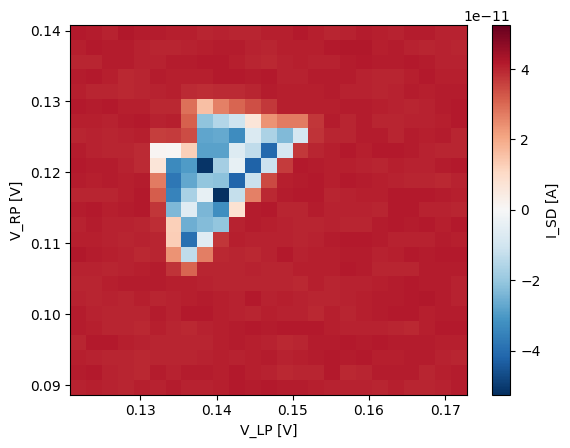

In [2]:
ds = load_by_guid('88a7e6c0-0000-0000-0000-018cd31dc951')
ds.to_xarray_dataset()["I_SD"].plot()

In [3]:
# local_ids = [7931]
# from qcodes.dataset import (
#     Measurement,
#     connect,
#     extract_runs_into_db,
#     load_experiment_by_name,
#     load_or_create_experiment,
# )
# source_conn = connect(db_name)
# target_path = "../data/GeSiNW_fully_autonomous_tuning.db"
# target_conn = connect(target_path)
# for _id in local_ids:
#     extract_runs_into_db(db_name, target_path, _id)

In [4]:
data_xarray = ds.to_xarray_dataset()

# Apply method

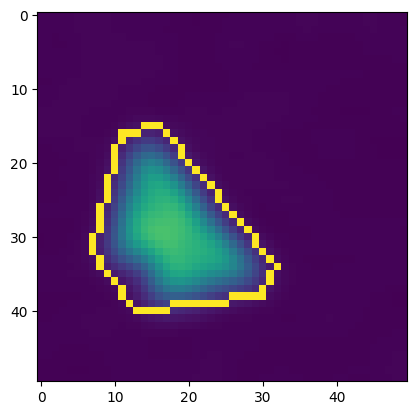

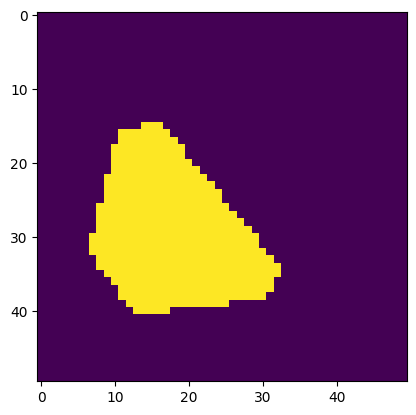

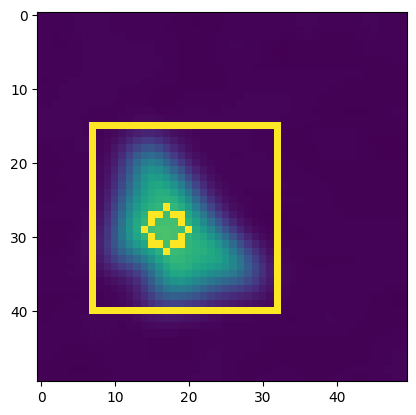

In [5]:
import sys
sys.path.append('../')
from bias_triangle_detection import btriangle_detection, btriangle_properties

invert_current = True
bias_direction = 'positive_bias'
if invert_current:
    data_analysis = -data_xarray["I_SD"].to_numpy()
else:
    data_analysis = data_xarray["I_SD"].to_numpy()

axes_values = []
axes_values_names = []
axes_units = []

for item, n in dict(data_xarray.dims).items():
    axes_values.append(data_xarray[item].to_numpy())
    axes_values_names.append(data_xarray[item].long_name)
    axes_units.append(data_xarray[item].unit)

res_h = 2
relative_min_area = 0.01
allow_MET = False
thr_method = 'triangle'
denoising = True
triangle_direction = "down"

if bias_direction == "positive_bias":
    pass
elif bias_direction == "negative_bias":
    data_analysis = data_analysis.T
else:
    raise NotImplementedError

min_area_h = (data_analysis.shape[0] * data_analysis.shape[1] * res_h * res_h) * relative_min_area

img, ims, masks = btriangle_detection.triangle_segmentation_alg(data_analysis,
                                                                res=res_h,
                                                                min_area=min_area_h,
                                                                thr_method=thr_method,
                                                                denoising=denoising,
                                                                allow_MET=allow_MET,
                                                                direction=triangle_direction
                                                                )
plt.imshow(ims[0])
plt.show()
plt.imshow(masks)
plt.show()
img_new, locations, bounding_boxes = btriangle_properties.location_and_box_by_contour(img, masks)
fig = plt.figure()
plt.imshow(img_new)
plt.show()


# Extract plunger voltages from segmentation

/Users/jonasschuff/Documents/Projects/fully-autonomous-tuning/demonstrations/../data_visualisation/utils.py:657: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


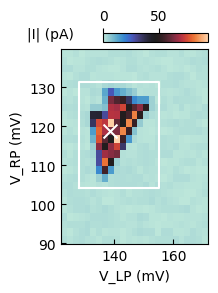

In [6]:

from data_visualisation.utils import plot_qcodes_data

if len(locations) > 1:
    center = np.array(img.shape)/2
    distance_to_center = np.linalg.norm(np.array(locations) - center, axis=-1)
    location = locations[np.argmin(distance_to_center)]
    bounding_box = bounding_boxes[np.argmin(distance_to_center)]
    location = location//res_h
else:
    location = locations[0]//res_h
    bounding_box = bounding_boxes[0]


if bias_direction == "positive_bias":
    rp = axes_values[0][location[1]]
    lp = axes_values[1][location[0]]
elif bias_direction == "negative_bias":
    rp = axes_values[0][location[0]]
    lp = axes_values[1][location[1]]
else:
    raise NotImplementedError

cmin, rmin, cmax, rmax = bounding_box

sidelength = max(rmax - rmin, cmax - cmin) // res_h

cmin, rmin, cmax, rmax = bounding_box

if bias_direction == "positive_bias":
    lp_min = axes_values[1][cmin // res_h]
    lp_max = axes_values[1][cmax // res_h]
    rp_min = axes_values[0][rmin // res_h]
    rp_max = axes_values[0][rmax // res_h]
elif bias_direction == "negative_bias":
    lp_min = axes_values[1][rmin // res_h]
    lp_max = axes_values[1][rmax // res_h]
    rp_min = axes_values[0][cmin // res_h]
    rp_max = axes_values[0][cmax // res_h]

box = np.array(
    [[lp_min, lp_max, lp_max, lp_min, lp_min], [rp_min, rp_min, rp_max, rp_max, rp_min]]).swapaxes(0, 1)


fig = plot_qcodes_data(
    data_xarray,
    mark=[lp, rp],
    box=box
)
plt.show()